In [1]:
import torch
from itertools import product
import pdb
import sys
from mnist import MNIST
# import cv2
import numpy as np

In [2]:
import torch.nn.functional as F

In [3]:
mndata = MNIST('./mnist/python-mnist/data/')
    # 载入数据
test_data_all, test_label_all = mndata.load_testing()
train_data_all, train_label_all = mndata.load_training()

test_data_all = torch.tensor(test_data_all).float()
train_label_all = torch.tensor(train_label_all)
test_label_all = torch.tensor(test_label_all)
train_data_all = torch.tensor(train_data_all).float()

In [4]:
# test_data, test_label = test_data_all[0:20], test_label_all[0:20]

In [5]:
train_data, train_label = train_data_all[0:100], train_label_all[0:100]

In [16]:
def get_feature(image):
    feature = image.view(1, 784)
    return feature

In [65]:
def model(feature, w1, w2, b1, b2):
#   feature = torch.cat((feature,torch.tensor(1.0).view(1,1)),1)
#   print(feature.shape)
    # 前向传播
    a1 = torch.mm(feature,w1) + b1
#     print('a1 ',a1.shape)
    z1 = torch.sigmoid(a1.float())
#     print('z1 ',z1.shape)
#     z1 = torch.cat((z1,torch.tensor(1.0).view(1,1)),1)
#     print('z1 ',z1.shape)
    a2 = torch.mm(z1, w2) + b2
#     print(a2)
    y = F.softmax(a2.float(), dim=1)
#     print(y)
#     y = torch.argmax(y, dim=1)
#     print(y)
    return y

In [66]:
res = model(train_data[1].view(1,784), w1,w2,b1,b2)
res

tensor([[2.3361e-06, 1.3124e-04, 1.8066e-05, 4.6106e-03, 9.4469e-06, 1.3556e-04,
         7.9291e-04, 5.0275e-07, 3.2133e-03, 9.9109e-01]],
       grad_fn=<SoftmaxBackward>)

In [8]:
def label2ground_truth(image_label):
    gt = torch.ones(10,10)
    gt = gt*-1.0
    #for label in image_label:
    for i in range(0,10):
        gt[i,i]=float(image_label[i])
    return gt

In [74]:
def one_hot(gt):
    gt_vector = torch.ones(1,10)
    gt_vector *= -0.1
    gt_vector[0,gt] = 0.9
    return gt_vector

In [75]:
one_hot(train_label[3])

tensor([[-0.1000,  0.9000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000,
         -0.1000, -0.1000]])

In [ ]:
def cross_entropy(y,t):
    

In [ ]:
def loss(x, t):
    y = model(x,w1,w2,b1,b2)
    return cross_entropy(y,t)

In [77]:
def get_acc(image_data,image_label,w1,w2,b1,b2, start_i,end_i):
    correct=0
    for i in range(start_i,end_i):
             #print(image_label[i])
             #y = model(get_feature(image_data[i]),weights)
        feature = get_feature(image_data[i])
        y = model(feature,w1,w2,b1,b2)
             #pdb.set_trace()
        gt = image_label[i]
             #pred=torch.argmin(torch.abs(y-gt)).item()
        pred = torch.argmax(y, dim=1)
             #pred = torch.argmin((torch.abs(y-1))).item()
             #print("图像[%s]得分类结果是:[%s]"%(gt,pred))
        if gt==pred:
            correct+=1
             
    #print("acc=%s"%(float(correct/20.0)))
    return  float(correct/float(end_i-start_i))

# print(image_train[1])
# y1 = predict(image_train[0:10].view(10,784))
# print(image_train[0:10].shape)
# t = np.argmax(y1.detach().numpy(), axis=0)
# print(y1)
# print(t)
def accuracy(image_data, image_label, w1, b1, w2, b2):
    acc = 0
    output = predict(image_data, w1, b1, w2, b2)
    y = torch.argmax(output, dim=1)
    cnt = torch.sum(y == image_label)
    acc = cnt.data.item() / image_data.shape[0]
    return acc


In [99]:
def train_model(image_data, image_label, w1, w2,b1,b2, lr = 0.1):
    loss_value_before=1000000000000000.
    loss_value=10000000000000.
    
    for epoch in range(300):
        loss_value_before = loss_value
        loss_value = 0
        for i in range(0,80):
            feature = get_feature(image_data[i])
            y = model(feature, w1, w2,b1,b2)
            gt = image_label[i]
            gt_vector = one_hot(gt).float()
            
#             print(gt_vector)
            loss = 0.5 * torch.sum((y-gt_vector).mul(y-gt_vector)).float()
#             loss = F.cross_entropy(y, image_label[i:i+1])
            loss_value += loss.data.item()
            loss.backward()
            
            w1.data.sub_(w1.grad.data*lr)
            w2.data.sub_(w2.grad.data*lr)
            b1.data.sub_(b1.grad.data*lr)
            b2.data.sub_(b2.grad.data*lr)
            w1.grad.data.zero_()
            w2.grad.data.zero_()
            b1.grad.data.zero_()
            b2.grad.data.zero_()
            
        train_acc = get_acc(image_data, image_label, w1,w2,b1,b2,0,80)
        test_acc = get_acc(image_data,image_label,w1,w2,b1,b2,80,100)
        print("epoch=%s,loss=%s/%s,train/test_acc=%s/%s,"%(epoch,loss_value,loss_value_before,train_acc,test_acc))
    
    return w1 ,w2,b1,b2

In [101]:
if __name__ == '__main__':

    w1 = torch.randn(784, 200, requires_grad=True)
    w2 = torch.randn(200, 10, requires_grad=True)
    b1 = torch.zeros(1, 200,requires_grad=True)
    b2 = torch.zeros(1, 10, requires_grad=True)
    
    w1, w2, b1, b2 = train_model(train_data, train_label, w1, w2,b1,b2)
    
    correct = 0
    for i in range(0,100):
        feature = get_feature(train_data[i])
        y = model(feature, w1, w2,b1,b2)
        gt = train_label[i]
        pred = torch.argmax(y, dim=1)
        if pred == gt:
            correct += 1
    
    print("acc: ", correct / float(100))

epoch=0,loss=65.54742728918791/10000000000000.0,train/test_acc=0.1875/0.25,
epoch=1,loss=62.85777333378792/65.54742728918791,train/test_acc=0.175/0.25,
epoch=2,loss=60.50642976537347/62.85777333378792,train/test_acc=0.225/0.2,
epoch=3,loss=57.45642592385411/60.50642976537347,train/test_acc=0.2875/0.3,
epoch=4,loss=55.70289558917284/57.45642592385411,train/test_acc=0.2875/0.2,
epoch=5,loss=54.11130578443408/55.70289558917284,train/test_acc=0.2875/0.2,
epoch=6,loss=53.541324198246/54.11130578443408,train/test_acc=0.2875/0.2,
epoch=7,loss=52.619110606610775/53.541324198246,train/test_acc=0.2875/0.2,
epoch=8,loss=51.6578932441771/52.619110606610775,train/test_acc=0.2875/0.25,
epoch=9,loss=51.72104113176465/51.6578932441771,train/test_acc=0.3375/0.3,
epoch=10,loss=48.552596271038055/51.72104113176465,train/test_acc=0.3375/0.25,
epoch=11,loss=49.159980319440365/48.552596271038055,train/test_acc=0.3625/0.35,
epoch=12,loss=47.350403387099504/49.159980319440365,train/test_acc=0.375/0.35,
epoch=

epoch=106,loss=21.513385709375143/21.525530602782965,train/test_acc=0.6875/0.4,
epoch=107,loss=21.500705629587173/21.513385709375143,train/test_acc=0.6875/0.4,
epoch=108,loss=21.486928779631853/21.500705629587173,train/test_acc=0.6875/0.4,
epoch=109,loss=21.47129399701953/21.486928779631853,train/test_acc=0.6875/0.45,
epoch=110,loss=21.452614787966013/21.47129399701953,train/test_acc=0.6875/0.45,
epoch=111,loss=21.428780775517225/21.452614787966013,train/test_acc=0.6875/0.45,
epoch=112,loss=21.395729511976242/21.428780775517225,train/test_acc=0.6875/0.45,
epoch=113,loss=21.348077457398176/21.395729511976242,train/test_acc=0.6875/0.45,
epoch=114,loss=21.29241805523634/21.348077457398176,train/test_acc=0.6875/0.45,
epoch=115,loss=21.256402496248484/21.29241805523634,train/test_acc=0.6875/0.45,
epoch=116,loss=21.243817444890738/21.256402496248484,train/test_acc=0.6875/0.45,
epoch=117,loss=21.235780850052834/21.243817444890738,train/test_acc=0.6875/0.45,
epoch=118,loss=21.226551838219166/2

epoch=210,loss=20.927526645362377/20.92813178524375,train/test_acc=0.6875/0.45,
epoch=211,loss=20.92691035196185/20.927526645362377,train/test_acc=0.6875/0.45,
epoch=212,loss=20.926278214901686/20.92691035196185,train/test_acc=0.6875/0.45,
epoch=213,loss=20.9256294593215/20.926278214901686,train/test_acc=0.6875/0.5,
epoch=214,loss=20.92496069893241/20.9256294593215,train/test_acc=0.6875/0.5,
epoch=215,loss=20.924270294606686/20.92496069893241,train/test_acc=0.6875/0.5,
epoch=216,loss=20.92355601489544/20.924270294606686,train/test_acc=0.6875/0.5,
epoch=217,loss=20.922814778983593/20.92355601489544,train/test_acc=0.6875/0.5,
epoch=218,loss=20.92204586789012/20.922814778983593,train/test_acc=0.6875/0.5,
epoch=219,loss=20.92124581709504/20.92204586789012,train/test_acc=0.6875/0.5,
epoch=220,loss=20.920411586761475/20.92124581709504,train/test_acc=0.6875/0.5,
epoch=221,loss=20.919542215764523/20.920411586761475,train/test_acc=0.6875/0.5,
epoch=222,loss=20.918632365763187/20.919542215764523

In [102]:
res = model(train_data[7].view(1,784), w1,w2,b1,b2)
pred = torch.argmax(res, dim=1)
print(pred)
print(train_label[7])


tensor([3])
tensor(3)


In [92]:
import matplotlib.pyplot as plt

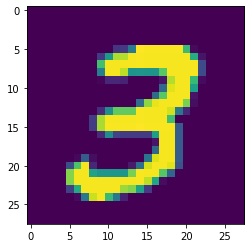

In [103]:
plt.imshow(train_data[7].detach().numpy().reshape(28,28))
plt.show()

In [ ]:
# def train_model(image_train, train_label, image_test, test_label, w1, w2, b1, b2, lrt=0.01):    
#     iter_nums = 1000
#     train_size = image_train.shape[0]
# #     batch_size = 10

#     train_loss_list = []
#     train_acc_list = []
#     test_acc_list = []
    
#     one_hot_train = onehot(train_label)
#     one_hot_test = onehot(test_label)

    
#     for i in range(iter_nums):
#         loss_last_epoch = 0
#         train_acc_epoch = 0
#         test_acc_epoch = 0
        
#         batch_mask = np.random.choice(100, 10)
#         train_epoch = image_train[batch_mask]
#         label_epoch = one_hot_train[batch_mask]

# #         for idx, img in enumerate(image_train):
#         y = predict(train_epoch, w1, b1, w2, b2)
#     #         print(y)
#         loss = torch.sum(0.5 * torch.mul((y - label_epoch), (y - label_epoch)))
#         train_loss_list.append(loss)
#         print('loss is ',loss.data.item())
#             # 反向传播计算梯度
#         loss.backward()
#         w1.data.sub_(w1.grad.data * lrt)
#         w2.data.sub_(w2.grad.data * lrt)
#         b1.data.sub_(b1.grad.data * lrt)
#         b2.data.sub_(b2.grad.data * lrt)
            
#         w1.grad.data.zero_()
#         b1.grad.data.zero_()
#         w2.grad.data.zero_()
#         b2.grad.data.zero_()

#         train_acc_epoch = accuracy(image_train, train_label, w1, b1, w2, b2)
#         test_acc_epoch = accuracy(image_test, test_label, w1, b1, w2, b2)

#         train_acc_list.append(train_acc_epoch)
#         test_acc_list.append(test_acc_epoch)
#         print('train acc, test acc  ' + str(test_acc_epoch) + ', ' + str(test_acc_epoch))
# #         print('loss is ', loss_last_epoch / 10)
        
#     return w1, w2, b1, b2

In [ ]:
# output1 = predict(image_test, w1,b1,w2,b2)
# print(output1)
# y = torch.argmax(output1, dim=1)
# gt = onehot(test_label)
# # print(gt)
# # cnt = torch.sum(y == test_label)
# # print('cnt = ', cnt )
# # print(image_test.shape[0])
# # print(cnt.data.item() / image_test.shape[0])
# # acc = accuracy(image_test, test_label, w1, b1, w2, b2)
# loss = torch.sum(0.5 * (output1 - gt).mul(output1 - gt))
# print(loss)
# loss.backward()

# # print(acc)
# # print(loss)
# print('w1 grad', sum(w1.grad))
# print('shape of grad w1',w1.grad.shape)
# print('w1 size',b1.shape)
# # print(output1)